<a href="https://colab.research.google.com/github/PattarapornH/Crab-Molting-Detection/blob/master/Molting_crab_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [32]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [33]:
path_dir = 'gdrive/My Drive/Year4/Project/top_view/Case9_2018_10_05_Coor(1_4_3_6)/'
# Case9_2018_10_05_Coor(1_4_3_6)
# Case10_2018_09_29_Coor(5_2)
path = []

for p in os.listdir(path_dir):
  # print(p)
  path.append(p)

path.sort()
path[0:10]

['0-13-22.png',
 '0-13-32.png',
 '0-13-42.png',
 '0-13-52.png',
 '0-14-02.png',
 '0-14-12.png',
 '0-14-22.png',
 '0-14-32.png',
 '0-14-42.png',
 '0-14-52.png']

In [0]:
from google.colab.patches import cv2_imshow

def plot_img(image):
  # shape = image.shape
  # img_resize = cv.resize(image,(int(shape[1]/2),int(shape[0]/2)))
  cv2_imshow(image)

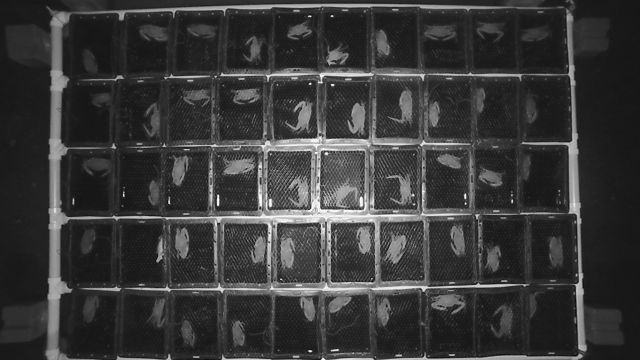

In [35]:
import cv2 as cv

data = []

for p in path:
  img = cv.imread(path_dir+'/'+p)
  shape = img.shape
  img_resize = cv.resize(img,(int(shape[1]/2),int(shape[0]/2)))
  data.append(img_resize)

plot_img(data[0])
# data[0].shape

In [36]:
len(data)

114

In [37]:
data[0].shape

(360, 640, 3)

# Equalize Histogram

..................................................................................................................
complete


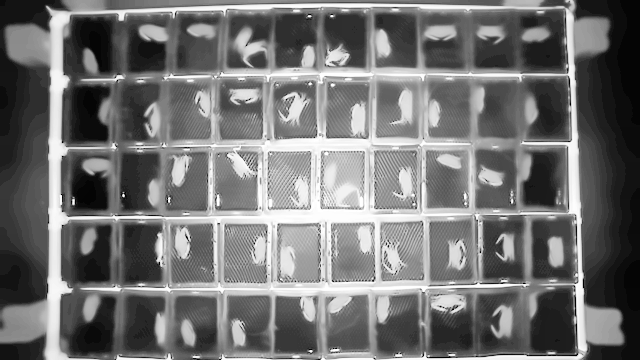

In [38]:
clean_data = []

for i in range(len(data)):
  print('.',end='')
  img = cv.fastNlMeansDenoisingColored(data[i],None,10,10,7,21)
  gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
  eq = cv.equalizeHist(gray)
  clahe = cv.createCLAHE(clipLimit=1.0, tileGridSize=(5,5))
  cl1 = clahe.apply(eq)
  clean_data.append(cl1)

print('\ncomplete')
plot_img(clean_data[-1])

In [39]:
len(clean_data)

114

..................................................................................................................

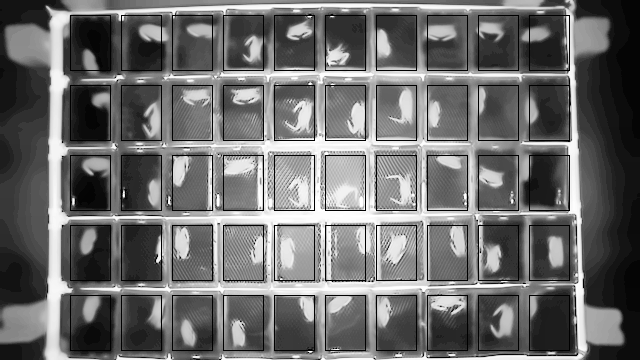

In [40]:
rect = []
series = dict()

START_X = 70
START_Y = 15
WIDTH = 40
HEIGHT = 55
DELTA_X = 51
DELTA_Y = 70
pos = ['A','B','C','D','E']

def draw_rect(img,time_series):
  for i in range(10):
    for j in range(5):
      x = START_X+(DELTA_X*i)
      y = START_Y+(DELTA_Y*j)
      cv.rectangle(img,(x,y),(x+WIDTH,y+HEIGHT),(0,255,0),1)
      if(pos[j]+str(i+1) not in time_series):
        time_series[pos[j]+str(i+1)] = [(img[y:y+HEIGHT,x:x+WIDTH],)]
      else:
        time_series[pos[j]+str(i+1)].append((img[y:y+HEIGHT,x:x+WIDTH],))

for i in range(len(clean_data)):
  print('.',end='')
  tmp = np.array(clean_data[i])
  # tmp = np.array(data[i])
  draw_rect(tmp,series)
  rect.append(tmp)
plot_img(rect[0])

In [41]:
len(rect)

114

In [0]:
# key = 'C6'
# series contain key(position) : [tuple(crop_img,theshold,mean),...,...]
for key in series:
  for i in range(len(series[key])):
    tmp = np.array(series[key][i][0])
    if(np.mean(tmp) > 50):
      tmp = cv.convertScaleAbs(tmp, alpha=1, beta=-(np.mean(tmp)-50))
    bll = cv.medianBlur(tmp,3)
    _, th1 = cv.threshold(bll, 70, 255,cv.THRESH_BINARY)
    series[key][i]  = series[key][i] + (th1,np.mean(th1))
  # print('key: {0}, mean: {1} {3}, index: {2}'.format(key,series[key][i][2],i,np.mean(th1)))
  # plot_img(series[key][i][0])
  # plot_img(bll)
  # plot_img(th1)

In [43]:
len(series)

50

In [44]:
# print(series['A1'][0][2])
# print(series['A1'][-1][2])
# b = False
for key in series.keys():
  list_mean = [x[2] for x in series[key]]
  # b = False
  # print(key,list_mean)
  # for i in range(len(list_mean)-1):
  #   for j in range(i+1,len(list_mean)):
  #     if(list_mean[j] - list_mean[i] > 20):
  #       print(key)
  #       b =True
  #       break
  #   if(b):
  #     break
  if(series[key][-1][2] - series[key][0][2] > 14):
    print(key)

A4
C6


In [0]:
time_series = dict()

for key in series:
  for i in range(len(series[key])-1):
    diff = np.count_nonzero(series[key][i+1][1] - series[key][i][1])
    if(key not in time_series):
      time_series[key] = [diff]
    else:
      time_series[key].append(diff)

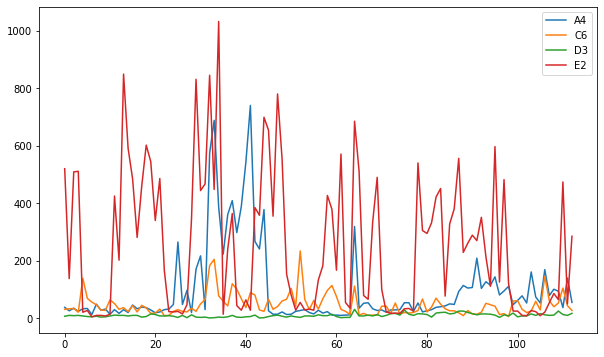

In [46]:
plt.figure(figsize=(10,6))
# for key in time_series:
#   plt.plot(time_series[key],label=key)
plt.plot(time_series['A4'],label='A4')
plt.plot(time_series['C6'],label='C6')
plt.plot(time_series['D3'],label='D3')
plt.plot(time_series['E2'],label='E2')
plt.legend()


## Label

In [0]:
X = []
y = []

In [0]:
for key in time_series.keys():
  X.append(time_series[key])
  if(key == 'A4' or key == 'C6'):
    y.append(1)
  else:
    y.append(0)

In [0]:
X = np.array(X)
y = np.array(y)
X = np.reshape(X, (X.shape[0], 1, X.shape[1]))

## Model

In [51]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)
y[0]

array([1., 0.], dtype=float32)

In [52]:
print(X.shape,y.shape)

(50, 1, 113) (50, 2)


In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [23]:
print(X_train.shape,y_train.shape)

(40, 1, 113) (40, 2)


In [81]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1:]), activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(20, activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_19 (LSTM)               (None, 1, 50)             32800     
_________________________________________________________________
dropout_28 (Dropout)         (None, 1, 50)             0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dropout_29 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                672       
_________________________________________________________________
dropout_30 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)               

In [82]:
class_weight = {0: 1.,
                1: 20.}
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'],)
train_model = model.fit(X_train,y_train,epochs=50, validation_split=0.3, class_weight=class_weight)

Train on 28 samples, validate on 12 samples
Epoch 1/50
28/28 [==============================] - 7s 267ms/step - loss: 1.7596 - acc: 0.7500 - val_loss: 0.6783 - val_acc: 0.5833
Epoch 2/50
28/28 [==============================] - 0s 481us/step - loss: 1.3170 - acc: 0.6429 - val_loss: 0.5945 - val_acc: 0.7500
Epoch 3/50
28/28 [==============================] - 0s 476us/step - loss: 1.6590 - acc: 0.8571 - val_loss: 0.5358 - val_acc: 0.9167
Epoch 4/50
28/28 [==============================] - 0s 353us/step - loss: 0.4304 - acc: 0.8214 - val_loss: 0.4596 - val_acc: 0.9167
Epoch 5/50
28/28 [==============================] - 0s 343us/step - loss: 1.2402 - acc: 0.7500 - val_loss: 0.3728 - val_acc: 1.0000
Epoch 6/50
28/28 [==============================] - 0s 336us/step - loss: 0.5676 - acc: 0.8929 - val_loss: 0.3257 - val_acc: 0.9167
Epoch 7/50
28/28 [==============================] - 0s 336us/step - loss: 1.0987 - acc: 0.8214 - val_loss: 0.2728 - val_acc: 1.0000
Epoch 8/50
28/28 [==============

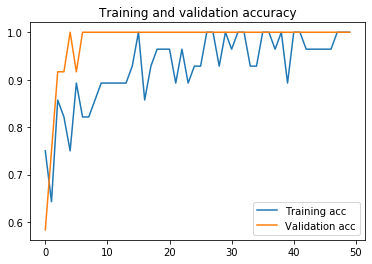

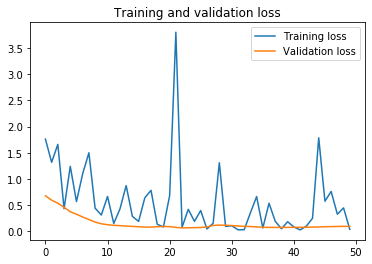

In [83]:
acc = train_model.history['acc']
val_acc = train_model.history['val_acc']
loss = train_model.history['loss']
val_loss = train_model.history['val_loss']


plt.plot(acc, label='Training acc')
plt.plot(val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(loss, label='Training loss')
plt.plot(val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
for key in time_series.keys():
  print(key)

In [0]:
y_pred = model.predict_classes(X)

In [85]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])